In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)
from sklearn.neighbors import NearestNeighbors
import joblib
from pathlib import Path
import json
import copy

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
figures_dir = Path("artifacts/figures")
figures_dir.mkdir(parents=True, exist_ok=True)

In [2]:
def basic_info(df : pd.DataFrame() , label : str):
    print(f'======Basic eda for data: {label}======\n\n')
    print(f'{df.head()}\n\n')
    print(f'Shape: {df.shape}\n\n')
    print(f'Info:\n\n{df.info}\n\n')
    print(f'Describe:\n\n{df.describe()}\n\n')
    print(f'Data types:\n\n{df.dtypes}\n\n')
    print(f'NaN values:\n\n{df.isna().sum()}\n\n')

def safe_cluster_metrics(X, labels):
    """Считает метрики; возвращает None, если метрика неприменима."""
    unique = np.unique(labels)
    # Нужно минимум 2 кластера
    if len(unique) < 2:
        return None

    # Нельзя, чтобы все точки были в одном кластере
    if len(unique) == 1:
        return None

    # silhouette требует, чтобы все кластеры имели >1 точки (часто, но не всегда)
    # В sklearn silhouette_score может падать, если какой-то кластер пуст/особый.
    try:
        sil = float(silhouette_score(X, labels))
    except Exception:
        sil = None

    try:
        db = float(davies_bouldin_score(X, labels))
    except Exception:
        db = None

    try:
        ch = float(calinski_harabasz_score(X, labels))
    except Exception:
        ch = None

    return {"silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch}

def pca_2d_for_plot(X_scaled, random_state=RANDOM_STATE):
    """PCA(2D) именно для визуализации."""
    p = PCA(n_components=2, random_state=random_state)
    return p.fit_transform(X_scaled)

def plot_2d_embedding(emb2d, labels, title, dataset: str):
    plt.figure(figsize=(7, 5))
    plt.scatter(emb2d[:, 0], emb2d[:, 1], c=labels, s=18)
    plt.title(title)
    plt.xlabel("dim-1")
    plt.ylabel("dim-2")
    plt.grid(True, alpha=0.2)


def summarize_labels(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique.tolist(), counts.tolist()))

def just_watch(X_num, label: str):
    #просто посмотреть на данные
    plt.hist(X_num, bins=10, edgecolor='black')
    plt.title(f"Гистограмма распределения: {label}")
    plt.xlabel("Значение")
    plt.ylabel("Частота")
    plt.savefig(figures_dir / f"hist_dist_{label}",)
    plt.show()

def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

In [3]:
df_1 = pd.read_csv('data/S07-hw-dataset-01.csv')
df_2 = pd.read_csv('data/S07-hw-dataset-02.csv')
df_3 = pd.read_csv('data/S07-hw-dataset-03.csv')
basic_info(df_1, 'S07-hw-dataset-01')
basic_info(df_2, 'S07-hw-dataset-02')
basic_info(df_3, 'S07-hw-dataset-03')

======Basic eda for data: S07-hw-dataset-01======


   sample_id        f01        f02       f03         f04        f05  \
0          0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1          1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2          2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
3          3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
4          4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   

         f06        f07       f08  
0 -12.291287  -6.836847 -0.504094  
1  34.316967 -49.468873  0.390356  
2  25.892951  44.595250  0.325893  
3   2.014316 -39.930582  0.139297  
4  -5.471054   7.001149  0.131213  


Shape: (12000, 9)


Info:

<bound method DataFrame.info of        sample_id        f01        f02       f03         f04        f05  \
0              0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1              1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2              2  1

In [4]:
X_1 = df_1.drop('sample_id', axis=1)
X_2 = df_2.drop('sample_id', axis=1)
X_3 = df_3.drop('sample_id', axis=1)
sample_id_1 = df_1['sample_id']
sample_id_2 = df_2['sample_id']
sample_id_3 = df_3['sample_id']

In [5]:
pca_dim = 8
kmeans_ks = list(range(2, 21))
dbscan_eps = [1.0, 2.5, 3.0, 3.5, 4.0]
dbscan_min_samples = [2, 6, 10]

print("Config:")
print(" pca_dim:", pca_dim)
print(" kmeans_ks:", (kmeans_ks[0], "...", kmeans_ks[-1]))
print(" dbscan eps:", dbscan_eps)
print(" dbscan min_samples:", dbscan_min_samples)

Config:
 pca_dim: 8
 kmeans_ks: (2, '...', 20)
 dbscan eps: [1.0, 2.5, 3.0, 3.5, 4.0]
 dbscan min_samples: [2, 6, 10]


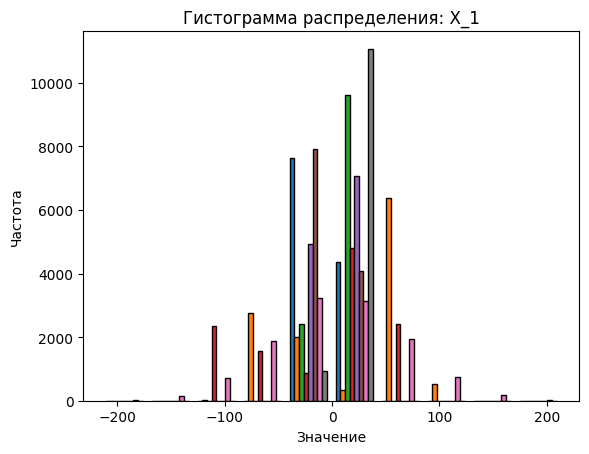

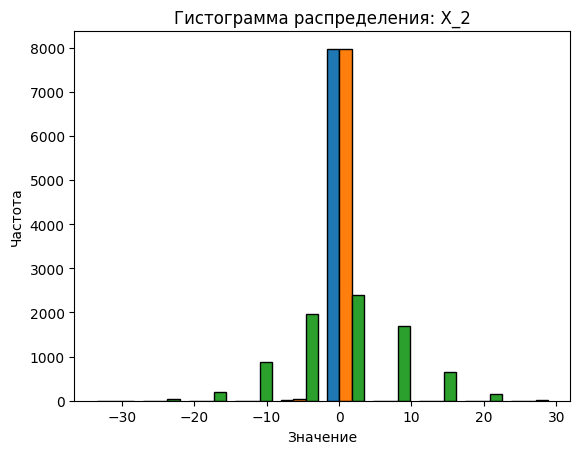

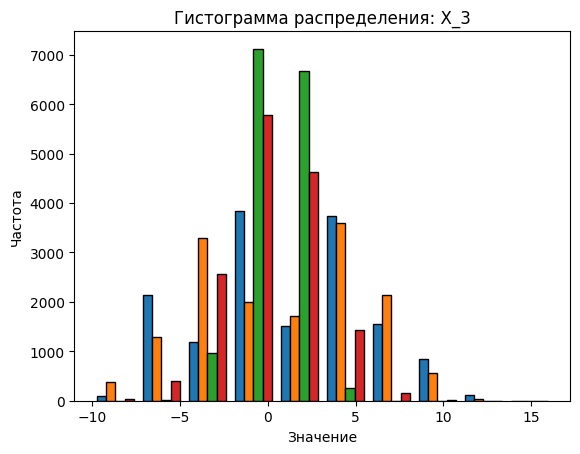

In [6]:
just_watch(X_1, 'X_1')
just_watch(X_2, 'X_2')
just_watch(X_3, 'X_3')

In [7]:
X_s = [X_1, X_2, X_3]
feated_X_s = []
scaled_X_s = []
for x in X_s:
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x)
    scaled_X_s.append(x_scaled)
    if pca_dim is None:
        x_feat = x_scaled
        pca_model = None
    else:
        pca_model = PCA(n_components=0.95, random_state=RANDOM_STATE)
        x_feat = pca_model.fit_transform(x_scaled)
    feated_X_s.append(x_feat)
print(scaled_X_s)
X_feat_1 = feated_X_s[0]
X_feat_2 = feated_X_s[1]
X_feat_3 = feated_X_s[2]
X_scaled_1 = scaled_X_s[0]
X_scaled_2 = scaled_X_s[1]
X_scaled_3 = scaled_X_s[2]

[array([[ 0.17142668, -1.46280499,  0.43827875, ..., -0.89591542,
        -0.11539556, -0.84301268],
       [ 1.60302144,  0.55306178, -2.1005838 , ...,  2.2545476 ,
        -0.83142723,  0.6304788 ],
       [ 1.90373017,  0.95758263, -2.19656934, ...,  1.68513022,
         0.74843886,  0.52428406],
       ...,
       [-0.46746486,  0.83750509,  0.12423596, ..., -0.42714879,
        -1.65916612,  1.36483461],
       [ 1.47828378,  1.1389387 , -2.41291263, ...,  1.91602935,
        -0.33375476,  0.48180103],
       [-1.16571448, -0.849189  ,  0.87345715, ...,  0.09937317,
        -1.7957767 , -0.92784466]], shape=(12000, 8)), array([[-0.39789177, -3.14730563,  2.61542782],
       [-1.57409478,  2.39537899,  0.7363646 ],
       [-1.64703263, -0.60266152, -2.35251356],
       ...,
       [ 0.20229915,  0.65430629, -0.32099036],
       [ 1.45797826,  0.07467672, -0.11895964],
       [ 1.52913739, -0.59689713, -0.70895773]], shape=(8000, 3)), array([[-0.86161489,  0.84136075, -0.80294603,  

1. S07-hw-dataset-01.csv

In [8]:
def eval_kmeans_grid(X_feat, ks):
    results = []
    for k in ks:
        try:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
        except TypeError:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)

        labels = model.fit_predict(X_feat)
        metrics = safe_cluster_metrics(X_feat, labels)

        results.append({
            "algo": "kmeans",
            "params": {"k": k},
            "labels": labels,
            "metrics": metrics,
            "inertia": float(model.inertia_),
            "n_clusters": len(np.unique(labels)),
            "noise_frac": 0.0,
        })
    return results

kmeans_results_1 = eval_kmeans_grid(X_feat_1, kmeans_ks)
len(kmeans_results_1), kmeans_results_1[0]["params"], kmeans_results_1[-1]["params"]

(19, {'k': 2}, {'k': 20})

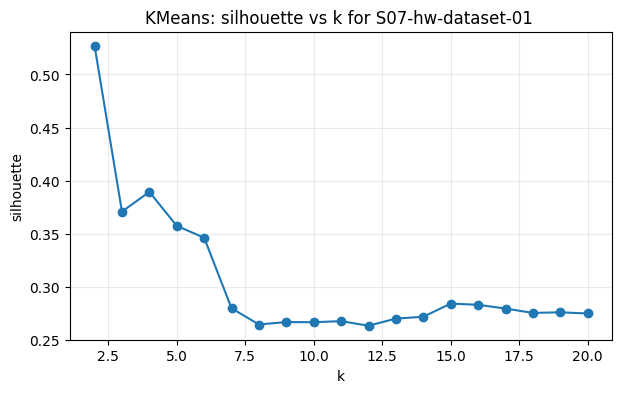

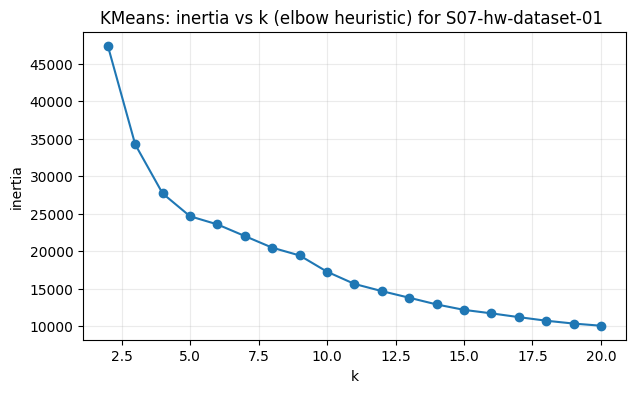

In [9]:
def silhouette_elbow_k_means(kmeans_results_num, label: str):
    ks = [r["params"]["k"] for r in kmeans_results_num]
    sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in kmeans_results_num]

    plt.figure(figsize=(7, 4))
    plt.plot(ks, sil, marker="o")
    plt.title(f"KMeans: silhouette vs k for {label} ")
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.grid(True, alpha=0.25)
    plt.savefig(figures_dir / f"silhuette_for_{label}")
    plt.show()


    inertia = [r["inertia"] for r in kmeans_results_num]
    plt.figure(figsize=(7, 4))
    plt.plot(ks, inertia, marker="o")
    plt.title(f"KMeans: inertia vs k (elbow heuristic) for {label} ")
    plt.xlabel("k")
    plt.ylabel("inertia")
    plt.grid(True, alpha=0.25)
    plt.savefig(figures_dir / f"silhuette_vs_k_for_{label}")
    plt.show()

silhouette_elbow_k_means(kmeans_results_1, 'S07-hw-dataset-01')

In [10]:
def kmeans_labels(X, k, random_state=RANDOM_STATE):
    # n_init='auto' – современный режим в sklearn; на старых версиях может потребоваться n_init=10
    try:
        model = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
    except TypeError:
        model = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    return model.fit_predict(X)
k_1st = [4, 5, 6]
def best_k_metrics(X_scaled_num, k_num):
    labels_k_num = kmeans_labels(X_scaled_num, k=k_num)
    print("k =", k_num)
    print("silhouette:", round(silhouette_score(X_scaled_num, labels_k_num), 3))
    print("davies_bouldin:", round(davies_bouldin_score(X_scaled_num, labels_k_num), 3))
    print("calinski_harabasz:", round(calinski_harabasz_score(X_scaled_num, labels_k_num), 1))
for k in k_1st:
    print('=' * 72)
    best_k_metrics(X_scaled_1, k)

k = 4
silhouette: 0.292
davies_bouldin: 1.431
calinski_harabasz: 7388.2
k = 5
silhouette: 0.311
davies_bouldin: 1.371
calinski_harabasz: 7648.0
k = 6
silhouette: 0.284
davies_bouldin: 1.439
calinski_harabasz: 7213.8


In [11]:
best_kmeans_1 = next(r for r in kmeans_results_1 if r["params"]["k"] == 5)
chosed_for_1st_kmeans = KMeans(n_clusters=5, random_state=RANDOM_STATE, n_init="auto")  #хочу сохранить лучшую модель

Исходя по данным метрикам я считаю, что для первого датасета число кластеров нужно обозначить 5 по методу k_means

видно, что количество кластеров выбрано оптимально, однако данные плоховато разделили

In [12]:
def eval_dbscan_grid(X_feat, eps_list, min_samples_list):
    results = []
    n = len(X_feat)

    for eps in eps_list:
        for ms in min_samples_list:
            model = DBSCAN(eps=eps, min_samples=ms)
            labels = model.fit_predict(X_feat)

            noise_frac = float(np.mean(labels == -1))
            # Метрики по non-noise
            mask = labels != -1
            labels_nn = labels[mask]
            X_nn = X_feat[mask]

            # Перенумеруем метки non-noise, чтобы метрики работали корректнее (не обязательно, но аккуратно)
            if len(labels_nn) > 0:
                uniq = np.unique(labels_nn)
                mapping = {u: i for i, u in enumerate(uniq)}
                labels_nn = np.array([mapping[v] for v in labels_nn], dtype=int)

            metrics = None
            n_clusters = 0
            if len(X_nn) >= 10 and len(np.unique(labels_nn)) >= 2:
                metrics = safe_cluster_metrics(X_nn, labels_nn)
                n_clusters = len(np.unique(labels_nn))

            results.append({
                "algo": "dbscan",
                "params": {"eps": float(eps), "min_samples": int(ms)},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": int(n_clusters),
                "noise_frac": float(noise_frac),
                "n_non_noise": int(mask.sum()),
            })
    return results
    
dbscan_results_1 = eval_dbscan_grid(X_feat_1, dbscan_eps, dbscan_min_samples)
len(dbscan_results_1)

15

In [13]:
valid_1 = [r for r in dbscan_results_1 if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
print("Valid DBSCAN configs:", len(valid_1))

# Сортировка по silhouette
valid_sorted_1 = sorted(valid_1, key=lambda r: r["metrics"]["silhouette"], reverse=True)
for r in valid_sorted_1[:8]:
    print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])
     

Valid DBSCAN configs: 6
{'eps': 2.5, 'min_samples': 2} sil= 0.527 noise= 0.0 clusters= 2
{'eps': 2.5, 'min_samples': 6} sil= 0.527 noise= 0.0 clusters= 2
{'eps': 2.5, 'min_samples': 10} sil= 0.527 noise= 0.0 clusters= 2
{'eps': 1.0, 'min_samples': 10} sil= 0.39 noise= 0.001 clusters= 4
{'eps': 1.0, 'min_samples': 6} sil= 0.39 noise= 0.001 clusters= 4
{'eps': 1.0, 'min_samples': 2} sil= 0.38 noise= 0.0 clusters= 5


посмотрев на прошлое разбиение данных в этом случае я выберу 5й конфиг лучшим.

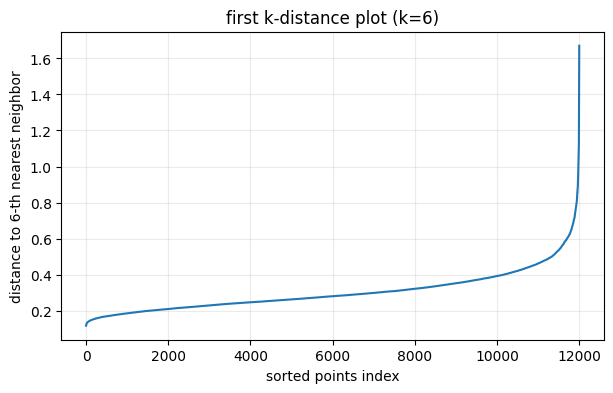

In [14]:
def k_distance_plot(X, k=6, title="k-distance plot"):
    nn = NearestNeighbors(n_neighbors=k)
    nn.fit(X)
    distances, _ = nn.kneighbors(X)  # distances shape: (n_samples, k)

    kth = np.sort(distances[:, -1])  # расстояние до k-го соседа
    plt.figure(figsize=(7, 4))
    plt.plot(kth)
    plt.title(f"{title} (k={k})")
    plt.xlabel("sorted points index")
    plt.ylabel(f"distance to {k}-th nearest neighbor")
    plt.grid(True, alpha=0.25)
    plt.show()

    return kth
    
kth_1 = k_distance_plot(X_feat_1, k=6, title="first k-distance plot")

In [15]:
best_min_sample_1 = [6]
best_eps_1 = [0.78]
dbscan_results_1 = eval_dbscan_grid(X_feat_1, best_eps_1, best_min_sample_1)
best_dbscan_1 = dbscan_results_1[0]
best_dbscan_1

{'algo': 'dbscan',
 'params': {'eps': 0.78, 'min_samples': 6},
 'labels': array([0, 1, 1, ..., 3, 1, 2], shape=(12000,)),
 'metrics': {'silhouette': 0.39022252425753545,
  'davies_bouldin': 1.140060504940064,
  'calinski_harabasz': 9787.034742675814},
 'inertia': None,
 'n_clusters': 4,
 'noise_frac': 0.0018333333333333333,
 'n_non_noise': 11978}

In [16]:
def print_result_card(name, result):
    m = result["metrics"] or {}
    print("=" * 72)
    print(f"{name}")
    print("algo:", result["algo"])
    print("params:", result["params"])
    print("n_clusters:", result.get("n_clusters"))
    if result["algo"] == "dbscan":
        print("noise_frac:", round(result.get("noise_frac", 0.0), 3), " non-noise:", result.get("n_non_noise"))
    print("metrics:")
    print("  silhouette:", None if m.get("silhouette") is None else round(m["silhouette"], 3))
    print("  davies_bouldin:", None if m.get("davies_bouldin") is None else round(m["davies_bouldin"], 3))
    print("  calinski_harabasz:", None if m.get("calinski_harabasz") is None else round(m["calinski_harabasz"], 1))
    if result.get("inertia") is not None:
        print("  inertia:", round(result["inertia"], 1))

print_result_card("BEST KMEANS (by silhouette) for 'S07-hw-dataset-01'", best_kmeans_1)
if best_dbscan_1 is not None:
    print_result_card("BEST DBSCAN (by silhouette among valid) for 'S07-hw-dataset-01' ", best_dbscan_1)


BEST KMEANS (by silhouette) for 'S07-hw-dataset-01'
algo: kmeans
params: {'k': 5}
n_clusters: 5
metrics:
  silhouette: 0.357
  davies_bouldin: 1.243
  calinski_harabasz: 8554.6
  inertia: 24644.5
BEST DBSCAN (by silhouette among valid) for 'S07-hw-dataset-01' 
algo: dbscan
params: {'eps': 0.78, 'min_samples': 6}
n_clusters: 4
noise_frac: 0.002  non-noise: 11978
metrics:
  silhouette: 0.39
  davies_bouldin: 1.14
  calinski_harabasz: 9787.0


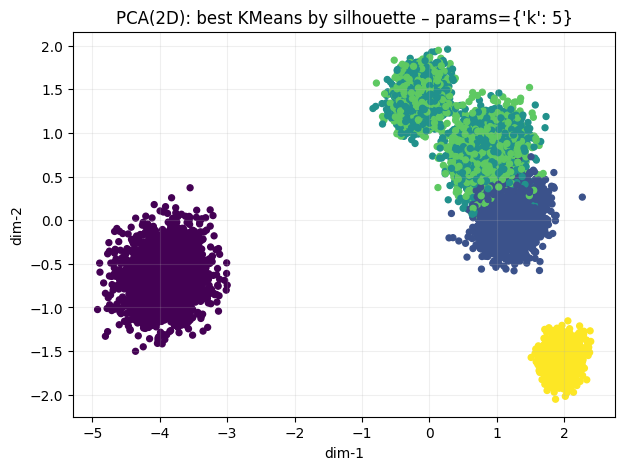

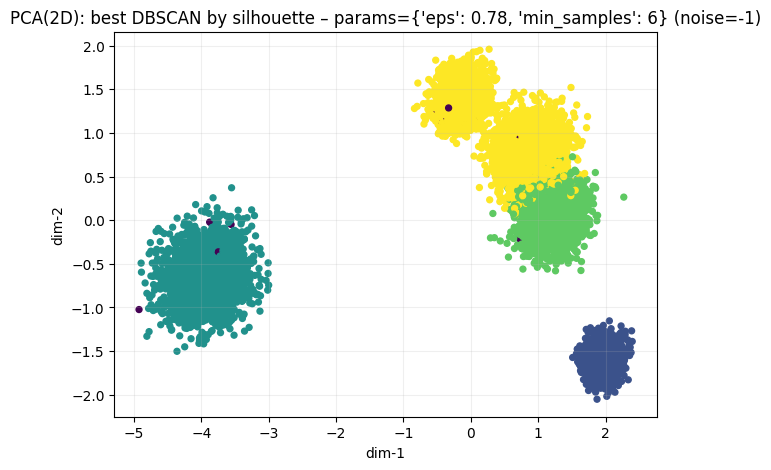

In [17]:
X_plot2d_1 = pca_2d_for_plot(X_scaled_1, random_state=RANDOM_STATE)

# KMeans best
plot_2d_embedding(
    X_plot2d_1, best_kmeans_1["labels"],
    title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans_1['params']}",
    dataset = 'S07-hw-dataset-01'
)
plt.savefig(figures_dir / 'best_kmeans_for_S07-hw-dataset-01')

if best_dbscan_1 is not None:
    plot_2d_embedding(
        X_plot2d_1, best_dbscan_1["labels"],
        title=f"PCA(2D): best DBSCAN by silhouette – params={best_dbscan_1['params']} (noise=-1)",
        dataset = 'S07-hw-dataset-01'
    )
plt.savefig(figures_dir / 'best_dbscan_for_S07-hw-dataset-01')

Для данного датасета по метрикам и 2d графику k_means определил правильное количество кластеров.

2. S07-hw-dataset-02

In [18]:
kmeans_results_2 = eval_kmeans_grid(X_feat_2, kmeans_ks)
len(kmeans_results_2), kmeans_results_2[0]["params"], kmeans_results_2[-1]["params"]

(19, {'k': 2}, {'k': 20})

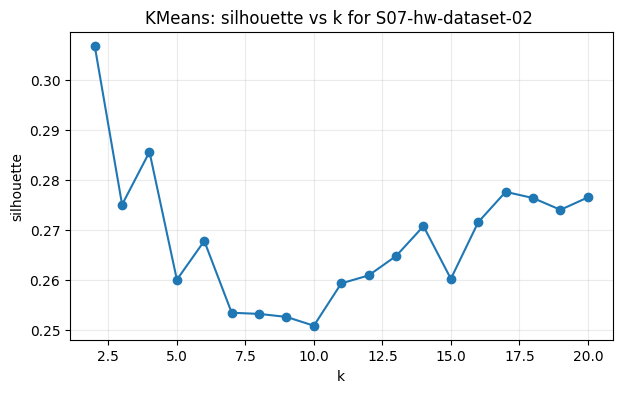

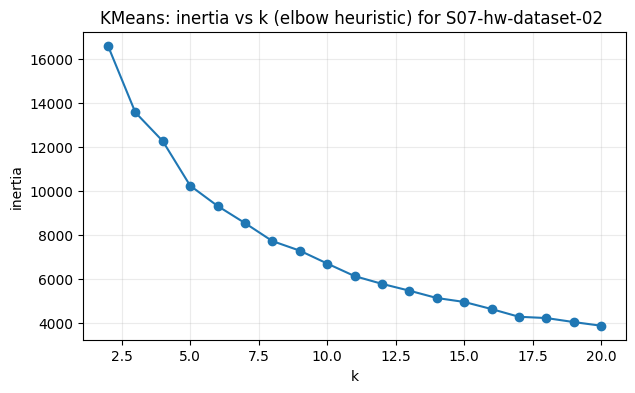

In [19]:
silhouette_elbow_k_means(kmeans_results_2, 'S07-hw-dataset-02')

In [20]:
k_2nd = [3, 4, 5, 6]
for k in k_2nd:
    print('=' * 72)
    best_k_metrics(X_scaled_2, k)

k = 3
silhouette: 0.275
davies_bouldin: 1.225
calinski_harabasz: 3077.7
k = 4
silhouette: 0.286
davies_bouldin: 1.141
calinski_harabasz: 2552.5
k = 5
silhouette: 0.26
davies_bouldin: 1.173
calinski_harabasz: 2687.1
k = 6
silhouette: 0.268
davies_bouldin: 1.12
calinski_harabasz: 2519.9


ориентируюсь по силуэту. Выбираю k=4

In [21]:
best_kmeans_2 = next(r for r in kmeans_results_2 if r["params"]["k"] == 4)
chosed_for_2nd_kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init="auto")  #хочу сохранить лучшую модель

In [22]:
dbscan_eps_2 = [0.5, 1.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
dbscan_min_samples_2 = [2, 4, 6, 8, 10] #из-за большой доли шума, меняю параметры подбора
dbscan_results_2 = eval_dbscan_grid(X_feat_2, dbscan_eps_2, dbscan_min_samples_2)
len(dbscan_results_2)

40

In [23]:
valid_2 = [r for r in dbscan_results_2 if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
print("Valid DBSCAN configs:", len(valid_2))

# Сортировка по silhouette
valid_sorted_2 = sorted(valid_2, key=lambda r: r["metrics"]["silhouette"], reverse=True)
for r in valid_sorted_2[:8]:
    print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])

Valid DBSCAN configs: 6
{'eps': 1.0, 'min_samples': 2} sil= 0.435 noise= 0.001 clusters= 4
{'eps': 0.5, 'min_samples': 10} sil= 0.251 noise= 0.064 clusters= 2
{'eps': 0.5, 'min_samples': 8} sil= 0.242 noise= 0.062 clusters= 3
{'eps': 0.5, 'min_samples': 6} sil= 0.022 noise= 0.052 clusters= 10
{'eps': 0.5, 'min_samples': 4} sil= -0.077 noise= 0.035 clusters= 24
{'eps': 0.5, 'min_samples': 2} sil= -0.259 noise= 0.015 clusters= 76


поскольку я знаю, что в данных большая доля шума, то выбираю 2-й конфиг для подбора eps

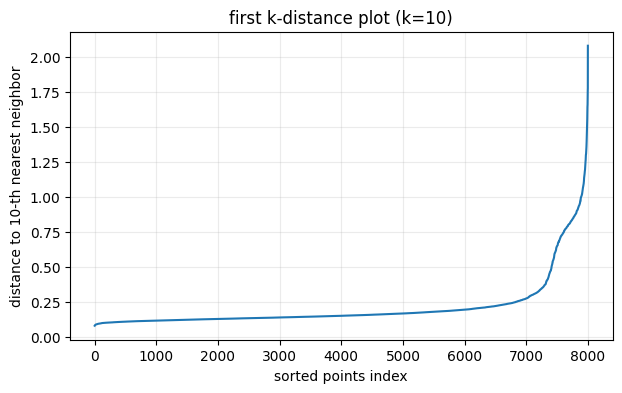

In [24]:
kth_2 = k_distance_plot(X_feat_2, k=10, title="first k-distance plot")

In [25]:
best_min_sample_2 = [10]
best_eps_2 = [0.5]
dbscan_results_2 = eval_dbscan_grid(X_feat_2, best_eps_2, best_min_sample_2)
best_dbscan_2 = dbscan_results_2[0]
best_dbscan_2

{'algo': 'dbscan',
 'params': {'eps': 0.5, 'min_samples': 10},
 'labels': array([-1, -1,  0, ...,  0,  0,  0], shape=(8000,)),
 'metrics': {'silhouette': 0.2512022545940147,
  'davies_bouldin': 0.7420731639720551,
  'calinski_harabasz': 26.168575636304755},
 'inertia': None,
 'n_clusters': 2,
 'noise_frac': 0.063625,
 'n_non_noise': 7491}

In [26]:
print_result_card("BEST KMEANS (by silhouette) for 'S07-hw-dataset-02'", best_kmeans_2)
if best_dbscan_2 is not None:
    print_result_card("BEST DBSCAN (by silhouette among valid) for 'S07-hw-dataset-02' ", best_dbscan_2)

BEST KMEANS (by silhouette) for 'S07-hw-dataset-02'
algo: kmeans
params: {'k': 4}
n_clusters: 4
metrics:
  silhouette: 0.286
  davies_bouldin: 1.141
  calinski_harabasz: 2552.5
  inertia: 12259.6
BEST DBSCAN (by silhouette among valid) for 'S07-hw-dataset-02' 
algo: dbscan
params: {'eps': 0.5, 'min_samples': 10}
n_clusters: 2
noise_frac: 0.064  non-noise: 7491
metrics:
  silhouette: 0.251
  davies_bouldin: 0.742
  calinski_harabasz: 26.2


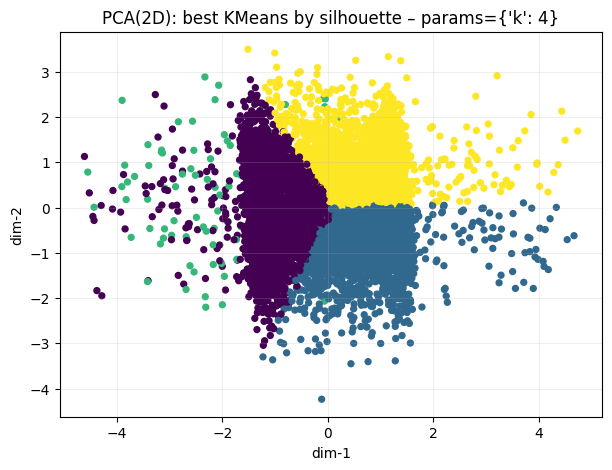

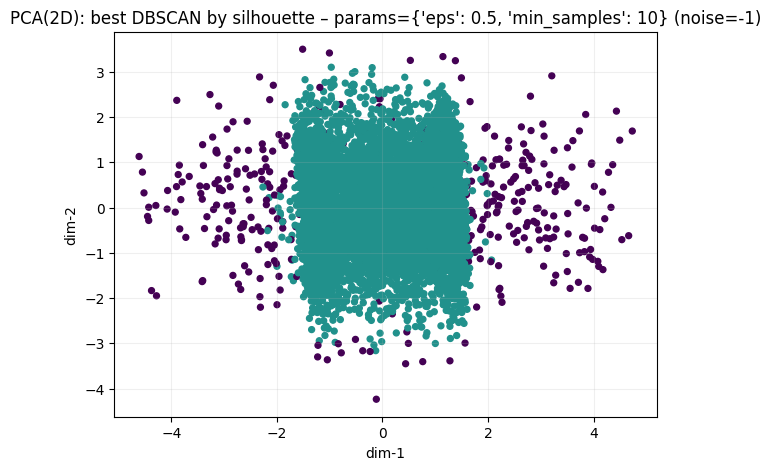

In [27]:
X_plot2d_2 = pca_2d_for_plot(X_scaled_2, random_state=RANDOM_STATE)

# KMeans best
plot_2d_embedding(
    X_plot2d_2, best_kmeans_2["labels"],
    title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans_2['params']}",
    dataset = 'S07-hw-dataset-02'
)
plt.savefig(figures_dir / 'best_kmeans_for_S07-hw-dataset-02')

if best_dbscan_2 is not None:
    plot_2d_embedding(
        X_plot2d_2, best_dbscan_2["labels"],
        title=f"PCA(2D): best DBSCAN by silhouette – params={best_dbscan_2['params']} (noise=-1)",
        dataset = 'S07-hw-dataset-02'
    )
plt.savefig(figures_dir / 'best_dbscan_for_S07-hw-dataset-02')

для данного датасета лучше справился как видно по графику dbscan. он классифицировал шум точнее. по davis_bouldin он выигрывает

3. S07-hw-dataset-03

In [28]:
kmeans_results_3 = eval_kmeans_grid(X_feat_3, kmeans_ks)
len(kmeans_results_3), kmeans_results_3[0]["params"], kmeans_results_3[-1]["params"]

(19, {'k': 2}, {'k': 20})

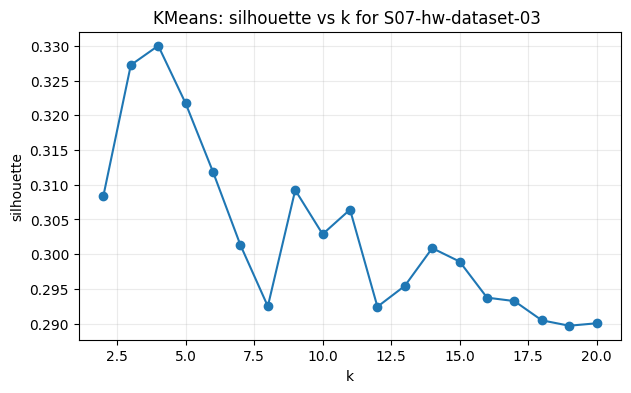

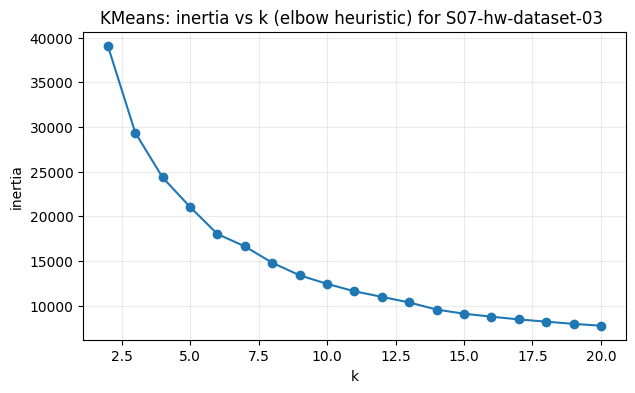

In [29]:
silhouette_elbow_k_means(kmeans_results_3, 'S07-hw-dataset-03')

In [30]:
k_3d = [4, 5, 9, 11]
for k in k_3d:
    print('=' * 72)
    best_k_metrics(X_scaled_3, k)

k = 4
silhouette: 0.315
davies_bouldin: 1.16
calinski_harabasz: 6492.3
k = 5
silhouette: 0.305
davies_bouldin: 1.103
calinski_harabasz: 6106.5
k = 9
silhouette: 0.263
davies_bouldin: 1.207
calinski_harabasz: 5348.1
k = 11
silhouette: 0.244
davies_bouldin: 1.277
calinski_harabasz: 4953.9


In [31]:
best_kmeans_3 = next(r for r in kmeans_results_3 if r["params"]["k"] == 4)
chosed_for_3d_kmeans = KMeans(n_clusters=4, random_state=RANDOM_STATE, n_init="auto")  #хочу сохранить лучшую модель
print(best_kmeans_3)

{'algo': 'kmeans', 'params': {'k': 4}, 'labels': array([0, 1, 1, ..., 1, 1, 1], shape=(15000,), dtype=int32), 'metrics': {'silhouette': 0.3300346435470066, 'davies_bouldin': 1.107746573338635, 'calinski_harabasz': 6941.4814815085}, 'inertia': 24342.928140934866, 'n_clusters': 4, 'noise_frac': 0.0}


In [32]:
dbscan_eps_3 = [0.2, 0.3, 0.5, 1.0, 1.5, 2.5]
dbscan_min_samples_3 = [2, 4, 6, 8, 10] #поменяю для третьего датасета поменять параметры для модели. поскольку там кроме шума еще и выбросы.
dbscan_results_3 = eval_dbscan_grid(X_feat_3, dbscan_eps_3, dbscan_min_samples_3)
len(dbscan_results_3)

30

In [33]:
valid_3 = [r for r in dbscan_results_3 if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
print("Valid DBSCAN configs:", len(valid_3))

# Сортировка по silhouette
valid_sorted_3 = sorted(valid_3, key=lambda r: r["metrics"]["silhouette"], reverse=True)
for r in valid_sorted_3[:8]:
    print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])

Valid DBSCAN configs: 12
{'eps': 0.3, 'min_samples': 8} sil= 0.27 noise= 0.057 clusters= 2
{'eps': 0.5, 'min_samples': 10} sil= 0.243 noise= 0.014 clusters= 2
{'eps': 0.3, 'min_samples': 10} sil= 0.204 noise= 0.069 clusters= 3
{'eps': 0.5, 'min_samples': 2} sil= -0.097 noise= 0.004 clusters= 15
{'eps': 0.3, 'min_samples': 6} sil= -0.143 noise= 0.045 clusters= 5
{'eps': 0.2, 'min_samples': 10} sil= -0.206 noise= 0.233 clusters= 19
{'eps': 0.2, 'min_samples': 8} sil= -0.248 noise= 0.186 clusters= 16
{'eps': 0.3, 'min_samples': 4} sil= -0.266 noise= 0.032 clusters= 8


выбираю третий конфиг. ориентируюсь по доле шума

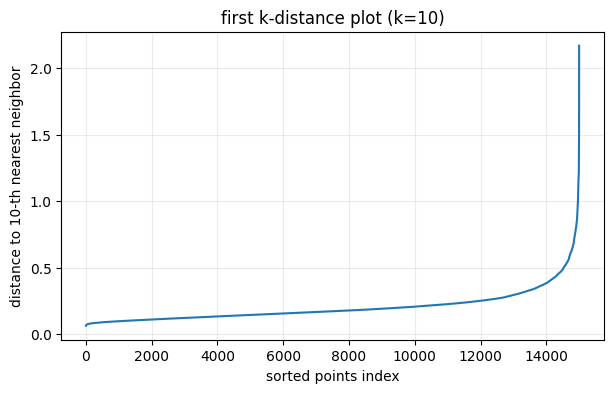

In [34]:
kth_3 = k_distance_plot(X_feat_3, k=10, title="first k-distance plot")

In [35]:
best_min_sample_3 = [10]
best_eps_3 = [0.48]
dbscan_results_3 = eval_dbscan_grid(X_feat_3, best_eps_3, best_min_sample_3)
best_dbscan_3 = dbscan_results_3[0]

In [36]:
best_dbscan_3 = valid_sorted_3[2] if valid_sorted_3 else None
best_dbscan_3["params"] if best_dbscan_3 else "No valid config found"

{'eps': 0.3, 'min_samples': 10}

In [37]:
print_result_card("BEST KMEANS (by silhouette) for 'S07-hw-dataset-03'", best_kmeans_3)
if best_dbscan_3 is not None:
    print_result_card("BEST DBSCAN (by silhouette among valid) for 'S07-hw-dataset-03' ", best_dbscan_3)

BEST KMEANS (by silhouette) for 'S07-hw-dataset-03'
algo: kmeans
params: {'k': 4}
n_clusters: 4
metrics:
  silhouette: 0.33
  davies_bouldin: 1.108
  calinski_harabasz: 6941.5
  inertia: 24342.9
BEST DBSCAN (by silhouette among valid) for 'S07-hw-dataset-03' 
algo: dbscan
params: {'eps': 0.3, 'min_samples': 10}
n_clusters: 3
noise_frac: 0.069  non-noise: 13960
metrics:
  silhouette: 0.204
  davies_bouldin: 1.131
  calinski_harabasz: 2255.9


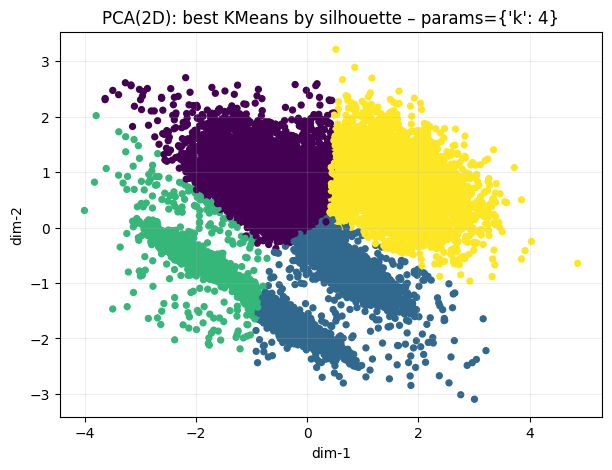

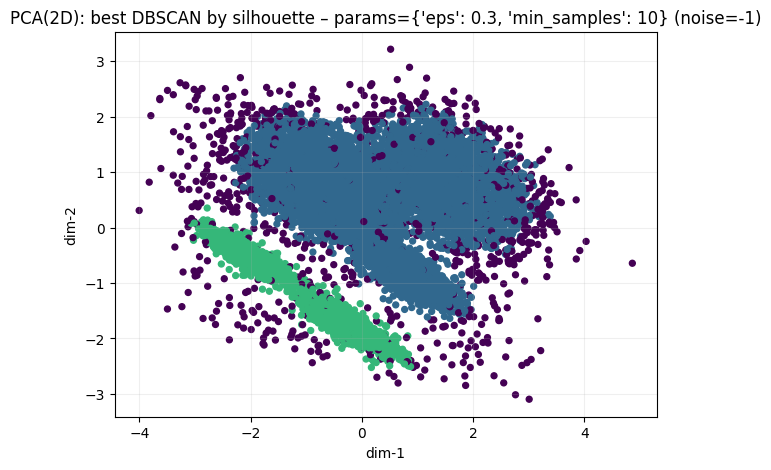

In [38]:
X_plot2d_3 = pca_2d_for_plot(X_scaled_3, random_state=RANDOM_STATE)

# KMeans best
plot_2d_embedding(
    X_plot2d_3, best_kmeans_3["labels"],
    title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans_3['params']}",
    dataset = 'S07-hw-dataset-03'
)
plt.savefig(figures_dir / 'best_kmeans_for_S07-hw-dataset-03')

if best_dbscan_3 is not None:
    plot_2d_embedding(
        X_plot2d_3, best_dbscan_3["labels"],
        title=f"PCA(2D): best DBSCAN by silhouette – params={best_dbscan_3['params']} (noise=-1)",
        dataset = 'S07-hw-dataset-03'
    )
plt.savefig(figures_dir / 'best_dbscan_for_S07-hw-dataset-03')

Таким образом, видно, что алгоритм K-means плохо справляется с кластеризацией данных, которые имеют выбросы, большую долю шума, неправильную (нешаробразную в данном случае) форму. При подборе параметров для алгоритмов ориентироваться лучше не только по силуэту, но и смотреть на другие метрики. Для третьего датасета тоже лучше справился dbscan.

4. Схранение результатов

In [39]:
def build_metrics_summary(best_kmeans_list, best_dbscan_list, dataset_names):
    summary = {}
    for name, km, db in zip(dataset_names, best_kmeans_list, best_dbscan_list):
        # KMeans metrics
        km_m = km["metrics"] or {}
        km_entry = {
            "silhouette": km_m.get("silhouette"),
            "davies_bouldin": km_m.get("davies_bouldin"),
            "calinski_harabasz": km_m.get("calinski_harabasz")
        }
        
        # DBSCAN metrics + noise fraction
        db_m = db["metrics"] or {}
        db_labels = db["labels"]
        noise_frac = float(np.mean(db_labels == -1)) if len(db_labels) > 0 else 0.0
        
        db_entry = {
            "silhouette": db_m.get("silhouette"),
            "davies_bouldin": db_m.get("davies_bouldin"),
            "calinski_harabasz": db_m.get("calinski_harabasz"),
            "noise_fraction": noise_frac
        }
        
        summary[name] = {
            "kmeans": km_entry,
            "dbscan": db_entry
        }
    return summary

def build_best_configs(best_kmeans_list, best_dbscan_list, dataset_names):
    configs = {}
    for name, km, db in zip(dataset_names, best_kmeans_list, best_dbscan_list):
        km_sil = km["metrics"].get("silhouette") if km["metrics"] else None
        db_sil = db["metrics"].get("silhouette") if db["metrics"] else None
        
        # Определяем лучший алгоритм по silhouette
        if km_sil is not None and db_sil is not None:
            best_algo = "kmeans" if km_sil >= db_sil else "dbscan"
        elif km_sil is not None:
            best_algo = "kmeans"
        elif db_sil is not None:
            best_algo = "dbscan"
        else:
            best_algo = "kmeans"  # fallback
        
        configs[name] = {
            "best_algo": best_algo,
            "selection_criterion": "max_silhouette",
            "kmeans": km["params"],
            "dbscan": db["params"]
        }
    return configs

In [41]:
dataset_names = [
    'S07-hw-dataset-01',
    'S07-hw-dataset-02',
    'S07-hw-dataset-03'
]

best_kmeans_list = [best_kmeans_1, best_kmeans_2, best_kmeans_3]
best_dbscan_list = [best_dbscan_1, best_dbscan_2, best_dbscan_3]

metrics_summary = build_metrics_summary(best_kmeans_list, best_dbscan_list, dataset_names)
save_path = ARTIFACTS_DIR / "metrics_summary.json"
save_json(metrics_summary, save_path)
print(f"saved: {save_path}")

best_configs = build_best_configs(best_kmeans_list, best_dbscan_list, dataset_names)
save_path = ARTIFACTS_DIR / "best_configs.json"
save_json(best_configs, save_path)
print(f"saved: {save_path}")

saved: artifacts\metrics_summary.json
saved: artifacts\best_configs.json


In [47]:
best_labels_1 = best_kmeans_1["labels"]
best_labels_2 = best_dbscan_2["labels"]   
best_labels_3 = best_dbscan_3["labels"]
LABELS_DIR = ARTIFACTS_DIR / "labels"
LABELS_DIR.mkdir(exist_ok=True)

pd.DataFrame({
    "sample_id": sample_id_1,          
    "cluster_label": best_labels_1
}).to_csv(LABELS_DIR / "labels_hw07_ds1.csv", index=False)

pd.DataFrame({
    "sample_id": sample_id_2,
    "cluster_label": best_labels_2
}).to_csv(LABELS_DIR / "labels_hw07_ds2.csv", index=False)

pd.DataFrame({
    "sample_id": sample_id_3,
    "cluster_label": best_labels_3
}).to_csv(LABELS_DIR / "labels_hw07_ds3.csv", index=False)

In [50]:
NEW_SEED = 52
k = 5
n_runs = 5
all_labels = []
np.random.seed(NEW_SEED)
random_states = np.random.choice(10000, size=n_runs, replace=False)

for rs in range(n_runs):
    model = KMeans(n_clusters=k, random_state=rs, n_init="auto")
    labels = model.fit_predict(X_feat_1)
    all_labels.append(labels)

ari_matrix = np.zeros((n_runs, n_runs))
for i in range(n_runs):
    for j in range(n_runs):
        ari_matrix[i, j] = adjusted_rand_score(all_labels[i], all_labels[j])

print("Average ARI:", ari_matrix[np.triu_indices(n_runs, k=1)].mean())

Average ARI: 0.6866481988043485
